In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.datasets.mnist as mnist

# Neural Network from Scratch

This notebook contains a detailed discussion and implementation of deep neural networks. Only numpy is used for matrix calculation. Rest of the code is developed from scratch. Each implementation contains an accompanying theoretical discussion along with it. It assumes that the reader has a basic understanding of vector calculation and how neural networks work.

## Dataset

MNIST handwritten digit dataset has been used for classification. The dataset contains 70,000 images of different digits (0-9). Each image is a 28x28 pixel grayscale image. The value of each pixel can be between 0 and 255 (inclusive). 

For the neural network, we convert the two dimensional image to a one dimensional vector consisting of 784 pixel values. Each pixel value is considered as a feature. We scale the value so that the value of each pixel ranges between 0 and 1 (inclusive).

__Dataset Architecture:__

Input shape [?, 784] : The input to the neural network contains a two dimensional matrix. The first dimension (?) contains the batch size (number of images provided to the network) and the second dimension (784) contains the number of features available for each sample.

Output Label [?, 10]: The output of the network contains two dimensional matrix. The first dimension (?) contains the batch size (number of images provided to the network) and the second dimension (10) contains the number of output classes available for the network.

Train dataset shape: (60000, 28, 28), train label shape: (60000,)
Test dataset shape: (10000, 28, 28), test label shape: (10000,)
Pixel value range: 0.0 - 1.0


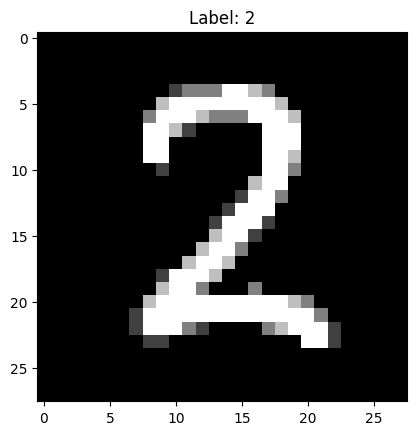

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train, X_test = X_train/255.0, X_test/255.0 # Scaling the dataset
print(f"Train dataset shape: {X_train.shape}, train label shape: {y_train.shape}")
print(f"Test dataset shape: {X_test.shape}, test label shape: {y_test.shape}")

print(f"Pixel value range: {np.min([np.min(X_train), np.min(X_test)])} - {np.max([np.max(X_train), np.max(X_test)])}")

plt.figure()
i = np.random.randint(0, len(X_train))
plt.title("Label: " + str(y_train[i]))
plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
plt.show()

## One hot encoding

In the dataset, the output label of each image is a value between 0-9. However, when performing classification the output of the network needs to be a probability distribution of each output class. This means that if we have an image of the digit '2' and the output class is the number '2', we need to convert that output to a vector as follows: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

This process of converting a number to a vector is known as one-hot encoding. The network itself will provide the output as a one-hot encoded vector of probability distribution. We need to convert the train and test labels to the same form in order to compute the error between the predicted and true output.

In [16]:
def one_hot_encoded(y, total_classes):
    """
    Calculates the one-hot encoded vector from the output label
    @param y [1D numpy array]: A vector containing output labels
    @param total_classes [int]: Number of total classes available in the output layer
    
    Returns [2D numpy array]: one-hot encoded vector for the output labels
    """
    if len(y.shape) >= 2:
        return y
    encoded = np.zeros((y.shape[0], total_classes))
    encoded[np.arange(y.shape[0]), y] = 1
    return encoded

In [18]:
sample_classes = np.array([0, 1, 2, 3])
one_hot_encoded_classes = one_hot_encoded(sample_classes, 10)
for i in range(len(sample_classes)):
    print(f"Label {sample_classes[i]} : One hot encoded vector => {one_hot_encoded_classes[i]}")

Label 0 : One hot encoded vector => [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Label 1 : One hot encoded vector => [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Label 2 : One hot encoded vector => [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Label 3 : One hot encoded vector => [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


## Activation Functions

Activation functions are used to introduce non-linearity to the output of a specific layer. The following activation functions are used for the network:

1. __Rectified Linear Unit (ReLU):__ This activation function is applied to the output of hidden layers. It reduces the likelihood of vanishing gradient. Furthermore, it introduces sparsity and it is easier to calculate the derivative of this function.


2. __Softmax:__ This activation function is applied to the final output produced by the output layer. It is used to calculate the probablity distributio of each output class/label. This helps in classification.

### ReLU

\begin{equation}
Y = f(x) = \begin{cases}
0 \text{ if } x < 0\\
x \text{ otherwise}
\end{cases}
\end{equation}

ReLU replaces all negative numbers to zero. The derivative of ReLU is calculated as follows:

\begin{equation}
Y' = f'(x) = \begin{cases}
0 \text{ if } x = 0\\
1 \text{ otherwise}
\end{cases}
\end{equation}

The slope of positive numbers are 1 as positive input to the function is same as the output of the function.



In [5]:
def relu(x):
    """
    Computes the ReLU activated output
    @aram x [numpy array or int]: The non-activated output
    Returns [numpy array or int]: The activated output
    """
    return np.maximum(0.0, x)

def derivative_relu(x):
    """
    Computes the derivative of the ReLU activated output
    @aram x [numpy array or int]: The activated output
    Returns [numpy array or int]: The derivative of the activated output
    """
    return np.where(x > 0, 1.0, 0.0)

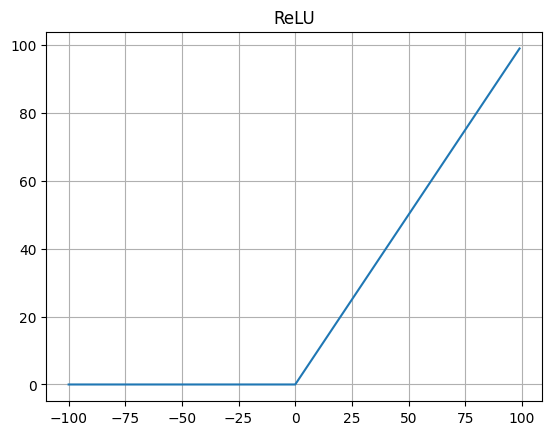

In [8]:
plt.figure()
plt.title('ReLU')
plt.plot(np.arange(-100, 100, 1), [relu(i) for i in np.arange(-100, 100, 1)])
plt.grid()
plt.show()

### Softmax

\begin{equation}
Y = f(x) = \frac{e^{x - max(x)}}{\sum_{i=0}^n e^{x - max(x)}}
\end{equation}

Here, 'n' is the total number of output classes (as this function is applied to the output layer only) which is 10.

Softmax takes each output (probability of class label) and exponentially increases it and finally scales it down to range between 0 and 1. It provides an advantage that the class output which has a higher probability is increased a lot (due to exponential increase) and after scaling becomes close to one. On the other hand, all other class labels become close to zero.

In [6]:
def softmax(x):
    """
    Computes the softmax activated output
    @aram x [2D numpy array]: The non-activated output provided by output layer
    Returns [2D numpy array]: The activated output provided by output layer
    """
    exp_x =  np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x/np.sum(exp_x, axis=1, keepdims=True)

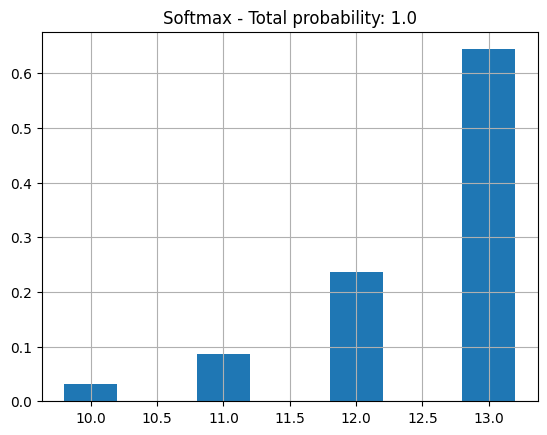

In [15]:
x = np.array([[10, 11, 12, 13]])
y = softmax(x)
plt.figure()
plt.title(f'Softmax - Total probability: {np.sum(y[0])}')
plt.bar(x[0], y[0], width=0.4)
plt.grid()
plt.show()

## Optimizers

When performing backpropagation algorithm, we normally use gradient descent to calculate the gradient of weights and biases of each layer. Optimization algorihms are a variant of gradient descent that is used to improve the performance of the backpropagation. We will use the following optimization algorithm:

1. Adagrad

2. RMSProp

3. Adam

Source: [https://www.geeksforgeeks.org/intuition-of-adam-optimizer/](https://www.geeksforgeeks.org/intuition-of-adam-optimizer/)

In [21]:
def adagrad(momentum, gradient_of_weight, beta=0.9):
    """
    Computes the adagrad optimization.
    @param momentum [2D numpy array]: Current momentum
    @param gradient_of_weight [2D numpy array]: Computed gradients of the weight of a layer
    @param beta [float]: Decay rate of average gradient
    Returns updated momentum and gradient_of_weight
    """
    momentum = (beta * momentum) + ((1 - beta) * gradient_of_weight)
    gradient_of_weight = momentum.copy()
    return momentum, gradient_of_weight

def rmsprop(sum_of_square, gradient_of_weight, beta=0.9999, epsilon=1e-8):
    """
    Computes the rmsprop optimization.
    @param sum_of_square [2D numpy array]: Current sum of squares of gradient
    @param gradient_of_weight [2D numpy array]: Computed gradients of the weight of a layer
    @param beta [float]: Decay rate of average gradient
    @param epsilon [float]: Small positive constant to avoid division by zero
    Returns updated sum_of_square and gradient_of_weight
    """
    sum_of_square = (beta * sum_of_square) + ((1 - beta) * np.square(gradient_of_weight))
    gradient_of_weight *= (1.0 /(np.sqrt(sum_of_square) + epsilon))
    return sum_of_square, gradient_of_weight

def adam(momentum, sum_of_square, gradient_of_weight, beta_1=0.9, beta_2=0.999, epsilon=1e-8):
    """
    Computes the adam optimization.
    @param momentum [2D numpy array]: Current momentum
    @param sum_of_square [2D numpy array]: Current sum of squares of gradient
    @param gradient_of_weight [2D numpy array]: Computed gradients of the weight of a layer
    @param beta_1 [float]: Decay rate of average gradient for adagrad calculation
    @param beta_2 [float]: Decay rate of average gradient for rmsprop calculation
    @param epsilon [float]: Small positive constant to avoid division by zero
    Returns updated momentum, sum_of_square, and gradient_of_weight
    """
    momentum = (beta_1 * momentum) + ((1 - beta_1) * gradient_of_weight)
    sum_of_square = (beta_2 * sum_of_square) + ((1 - beta_2) * np.square(gradient_of_weight))
    gradient_of_weight = momentum/(np.sqrt(sum_of_square) + epsilon)
    return momentum, sum_of_square, gradient_of_weight

## Loss and Accuracy

When training the network, we need to periodically test the accuracy and loss of the network. Categorical Crossentropy is an algorithm that is used to calculate the loss of the network by comparing the true output label with the output predictions provided by the network.

In [22]:
def categorical_crossentropy(y_true, y_pred):
    """
    Computes categorical crossentropy between the predicted and true labels.
    @param y_true [2D Numpy array]: True labels, shape (num_examples, num_classes)
    @pram y_pred [2D Numpy array]: Predicted labels, shape (num_examples, num_classes)

    Returns [float]: the categorical crossentropy loss between y_true and y_pred
    """
    # Avoid numerical instability by clipping values to a minimum epsilon
    epsilon = 1e-10
    y_pred = np.clip(y_pred, epsilon, 1.0 - epsilon)

    # Compute cross-entropy loss
    ce_loss = -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]

    return ce_loss

def accuracy(y_true, y_pred):
    """
    Computes accuracy of the network based on the predicted output and the expected/true output.
    @param y_true [2D Numpy array]: True labels, shape (num_examples, num_classes)
    @pram y_pred [2D Numpy array]: Predicted labels, shape (num_examples, num_classes)

    Returns [float]: the accuracy of the network
    """
    return np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1))

## Forward propagation

\begin{equation}
Output, a = Activation(W.x + b)
\end{equation}

Here,

- 'W' is the weight matrix of the current layer

- 'x' is the input matrix provided to the current layer

- 'b' is the bias for the current layer

If the previous layer 'A' contains 2 neurons and the current layer 'B' contains 3 neurons, then the weight matrix

\begin{equation}
W = \left\lbrack \matrix{W_{A_1B_1} W_{A_1B_2} W_{A_1B_3} \cr W_{A_2B_1} W_{A_2B_2} W_{A_2B_3}} \right\rbrack
\end{equation}

The input (assuming it contains 1 sample input

\begin{equation}
x = \left\lbrack \matrix{x_{A_1} x_{A_2}} \right\rbrack
\end{equation}

and the bias of the current layer

\begin{equation}
b = \left\lbrack \matrix{b_{B_1} b_{B_2} b_{B_3}} \right\rbrack
\end{equation}

Therefore the non-activated output

\begin{equation}
z = \left\lbrack \matrix{z_{B_1} z_{B_2} z_{B_3}} \right\rbrack
\end{equation}

In [24]:
def feed_forward(x, W, b, activation):
    """
    Returns the activated output for a layer.
    @param x [2D numpy array] : The input to the current layer. First dimension is the number of samples 
    and the second dimension is the number of features of each sample.
    
    @param W [2D numpy array] : The weight of the current layer. First dimension is the number of 
    neurons in previous layer/input and the second dimension is the number of neurons in current layer.
    
    @param b [2D numpy array] : Bias of the current layer. The 
    first dimension is always 1 and the second dimension is the number of neurons in current layer
    
    @param activation [function]: The activation function for the current layer.
    """
    return activation(np.dot(x, W) + b)